In [1]:
import pandas as pd
import numpy as np

%matplotlib inline

### Walmart Sales Data

For the independent practice, we will analyze the weekly sales data from Walmart over a two year period from 2010 to 2012.

The data is again separated by store and by department, but we will focus on analyzing one store for simplicity.

The data includes:

- Store - the store number
- Dept - the department number
- Date - the week
- Weekly_Sales -  sales for the given department in the given store
- IsHoliday - whether the week is a special holiday week


#### Loading the data and setting the DateTimeIndex

In [8]:
data = pd.read_csv('../dataset/train.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data.head()

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-02-05,1,1,24924.50,False
2010-02-12,1,1,46039.49,True
2010-02-19,1,1,41595.55,False
2010-02-26,1,1,19403.54,False
2010-03-05,1,1,21827.90,False


#### Filter the dataframe to Store 1 sales and aggregate over departments to compute the total sales per store.

In [9]:
# Filter to store 1 sales and average over weeks
store1_sales = data[data.Store == 1][['Weekly_Sales']].resample('W').sum()
store1_sales.head()

,Weekly_Sales
Date,
2010-02-07,1643690.90
2010-02-14,1641957.44
2010-02-21,1611968.17
2010-02-28,1409727.59
2010-03-07,1554806.68


#### Plot the rolling_mean for `Weekly_Sales`. What general trends do you observe?

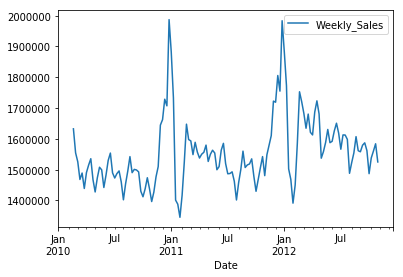

In [12]:
store1_sales[['Weekly_Sales']].rolling(window=3).mean().plot()

#### Compute the 1, 2, 52 autocorrelations for `Weekly_Sales` and/or create an autocorrelation plot.

In [13]:
print('Autocorrelation 1: ', store1_sales['Weekly_Sales'].autocorr(1))
print('Autocorrelation 3: ', store1_sales['Weekly_Sales'].autocorr(3))
print('Autocorrelation 52: ', store1_sales['Weekly_Sales'].autocorr(52))

('Autocorrelation 1: ', 0.30215827941131251)
('Autocorrelation 3: ', 0.059799235066717034)
('Autocorrelation 52: ', 0.89537602947770079)


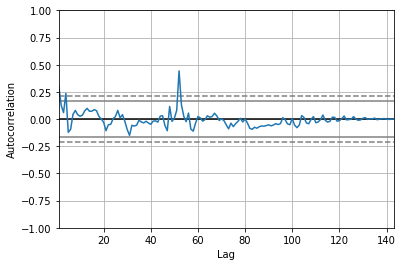

In [14]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(store1_sales['Weekly_Sales'])

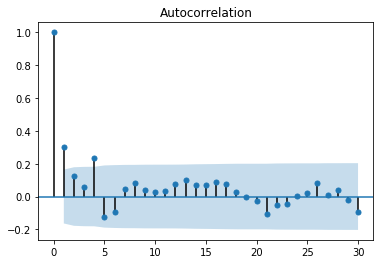

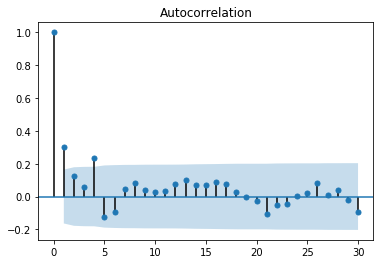

In [15]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(store1_sales['Weekly_Sales'], lags=30)

# Components 1 and 2 seem particularly useful for autoregression, perhaps up to 4
# In the plot above notice, spike at around 52 - implying a yearly pattern as well
# No random spikes, probably not much use for a moving average model

#### Split the weekly sales data in a training and test set - using 75% of the data for training

In [16]:
n = len(store1_sales.Weekly_Sales)

train = store1_sales.Weekly_Sales[:int(.75*n)]
test = store1_sales.Weekly_Sales[int(.75*n):]

In [17]:
type(train)

pandas.core.series.Series

#### Create an AR(1) model on the training data and compute the mean absolute error of the predictions.

In [18]:
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error

In [19]:
model = sm.tsa.ARIMA(train, (1, 0, 0)).fit()

predictions = model.predict(
    '2012-02-27',
    '2012-10-29',
    dynamic=True, 
)

print("Mean absolute error: ", mean_absolute_error(test, predictions))
model.summary()

('Mean absolute error: ', 81839.338631623992)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           Weekly_Sales   No. Observations:                  107
Model:                     ARMA(1, 0)   Log Likelihood               -1434.663
Method:                       css-mle   S.D. of innovations         160916.939
Date:                Wed, 27 Dec 2017   AIC                           2875.327
Time:                        11:18:18   BIC                           2883.345
Sample:                    02-07-2010   HQIC                          2878.577
                         - 02-19-2012                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1.544e+06   2.26e+04     68.293      0.000     1.5e+06    1.59e+06
ar.L1.Weekly_Sales     0.3147      0.093      3.399      0.001       0.133       0.496
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            3.1779           +0.0000j            3.1779            0.0000
-----------------------------------------------------------------------------
"""

In [21]:
test.keys()

DatetimeIndex(['2012-02-26', '2012-03-04', '2012-03-11', '2012-03-18',
               '2012-03-25', '2012-04-01', '2012-04-08', '2012-04-15',
               '2012-04-22', '2012-04-29', '2012-05-06', '2012-05-13',
               '2012-05-20', '2012-05-27', '2012-06-03', '2012-06-10',
               '2012-06-17', '2012-06-24', '2012-07-01', '2012-07-08',
               '2012-07-15', '2012-07-22', '2012-07-29', '2012-08-05',
               '2012-08-12', '2012-08-19', '2012-08-26', '2012-09-02',
               '2012-09-09', '2012-09-16', '2012-09-23', '2012-09-30',
               '2012-10-07', '2012-10-14', '2012-10-21', '2012-10-28'],
              dtype='datetime64[ns]', name=u'Date', freq='W-SUN')

#### Plot the residuals - where are their significant errors.

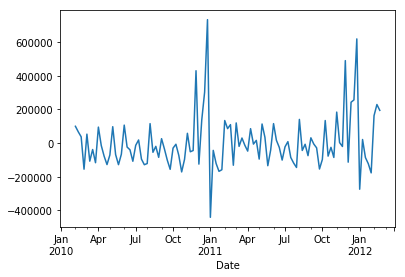

In [22]:
model.resid.plot()

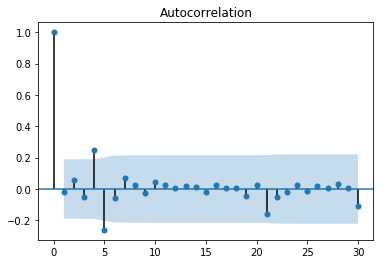

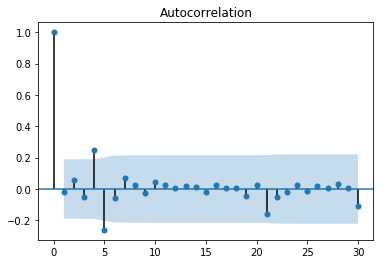

In [23]:
plot_acf(model.resid, lags=30)

#### Compute and AR(2) model and an ARMA(2, 2) model - does this improve your mean absolute error on the held out set.

In [24]:
model = sm.tsa.ARIMA(train, (2, 0, 0)).fit()

predictions = model.predict(
    '2012-02-27',
    '2012-10-29',
    dynamic=True, 
)

print("Mean absolute error: ", mean_absolute_error(test, predictions))
model.summary()

('Mean absolute error: ', 81203.234625738813)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           Weekly_Sales   No. Observations:                  107
Model:                     ARMA(2, 0)   Log Likelihood               -1434.482
Method:                       css-mle   S.D. of innovations         160638.038
Date:                Wed, 27 Dec 2017   AIC                           2876.963
Time:                        11:18:41   BIC                           2887.655
Sample:                    02-07-2010   HQIC                          2881.298
                         - 02-19-2012                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1.544e+06    2.4e+04     64.349      0.000     1.5e+06    1.59e+06
ar.L1.Weekly_Sales     0.2974      0.097      3.075      0.003       0.108       0.487
ar.L2.Weekly_Sales     0.0589      0.098      0.603      0.548      -0.132       0.250
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.3080           +0.0000j            2.3080            0.0000
AR.2           -7.3587           +0.0000j            7.3587            0.5000
-----------------------------------------------------------------------------
"""

In [25]:
model = sm.tsa.ARIMA(train, (2, 0, 2)).fit()

predictions = model.predict(
    '2012-02-27',
    '2012-10-29',
    dynamic=True, 
)

print("Mean absolute error: ", mean_absolute_error(test, predictions))
model.summary()

('Mean absolute error: ', 80502.240139467569)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           Weekly_Sales   No. Observations:                  107
Model:                     ARMA(2, 2)   Log Likelihood               -1425.781
Method:                       css-mle   S.D. of innovations         144117.218
Date:                Wed, 27 Dec 2017   AIC                           2863.563
Time:                        11:18:51   BIC                           2879.600
Sample:                    02-07-2010   HQIC                          2870.064
                         - 02-19-2012                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1.544e+06   1.92e+04     80.320      0.000    1.51e+06    1.58e+06
ar.L1.Weekly_Sales    -1.0398      0.090    -11.583      0.000      -1.216      -0.864
ar.L2.Weekly_Sales    -0.4701      0.087     -5.380      0.000      -0.641      -0.299
ma.L1.Weekly_Sales     1.4691      0.058     25.341      0.000       1.355       1.583
ma.L2.Weekly_Sales     0.9997      0.074     13.533      0.000       0.855       1.145
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.1059           -0.9509j            1.4585           -0.3870
AR.2           -1.1059           +0.9509j            1.4585            0.3870
MA.1           -0.7347           -0.6785j            1.0001           -0.3813
MA.2           -0.7347           +0.6785j            1.0001            0.3813
-----------------------------------------------------------------------------
"""

#### Finally, compute an ARIMA model to improve your prediction error - iterate on the p, q, and parameters comparing the model's performance.

In [26]:
model = sm.tsa.ARIMA(train, (2, 1, 3)).fit()

predictions = model.predict(
    '2012-02-27',
    '2012-10-29',
    dynamic=False, 
    typ='levels'
)

print("Mean absolute error: ", mean_absolute_error(test, predictions))
model.summary()

('Mean absolute error: ', 77715.144893794612)


/Users/naumz/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/naumz/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:         D.Weekly_Sales   No. Observations:                  106
Model:                 ARIMA(2, 1, 3)   Log Likelihood               -1413.663
Method:                       css-mle   S.D. of innovations         142989.041
Date:                Wed, 27 Dec 2017   AIC                           2841.325
Time:                        11:18:58   BIC                           2859.969
Sample:                    02-14-2010   HQIC                          2848.882
                         - 02-19-2012                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  553.2547    623.172      0.888      0.377    -668.140    1774.649
ar.L1.D.Weekly_Sales    -1.0481      0.090    -11.600      0.000      -1.225      -0.871
ar.L2.D.Weekly_Sales    -0.4783      0.088     -5.443      0.000      -0.651      -0.306
ma.L1.D.Weekly_Sales     0.4694      0.357      1.316      0.191      -0.230       1.169
ma.L2.D.Weekly_Sales    -0.4693      0.519     -0.905      0.368      -1.486       0.547
ma.L3.D.Weekly_Sales    -0.9999      0.359     -2.783      0.006      -1.704      -0.296
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.0956           -0.9435j            1.4459           -0.3869
AR.2           -1.0956           +0.9435j            1.4459            0.3869
MA.1            1.0000           -0.0000j            1.0000           -0.0000
MA.2           -0.7347           -0.6784j            1.0000           -0.3813
MA.3           -0.7347           +0.6784j            1.0000            0.3813
-----------------------------------------------------------------------------
"""